In [1]:
import keras
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas
from keras import Sequential
from keras.layers import *
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import keras.callbacks as callbacks
from keras.utils import multi_gpu_model

Using TensorFlow backend.


input1 = Missing image (Masked by cloud)

input2 = Referenced images (cloud-free)

### Implement Model

In [2]:
input1 = Input(shape=(400,400,1), name='input1')
input2 = Input(shape=(400,400,1), name='input2')
input3 = Input(shape=(400,400,1), name='input3')

conv_1 = Conv2D(30, (3, 3), padding='same')(input1)
conv_2 = Conv2D(30, (3, 3), padding='same')(input2)
conv_3 = Conv2D(60, (3, 3), padding='same')(input3)

concat_1_2 = concatenate([conv_1, conv_2], axis=-1)
concat_1_2 = Activation('relu')(concat_1_2)

concat_1_2 = Dropout(0.3)(concat_1_2)

feature_3 = Conv2D(filters=20, kernel_size=(9, 9),padding='same')(concat_1_2)
feature_5 = Conv2D(filters=20, kernel_size=(5, 5),padding='same')(concat_1_2)
feature_7 = Conv2D(filters=20, kernel_size=(7, 7),padding='same')(concat_1_2)
feature_3_5_7 = concatenate([feature_3, feature_5, feature_7])
feature_3_5_7 = Activation('relu')(feature_3_5_7)

# feature_3_5_7 = Dropout(0.3)(feature_3_5_7)

sum0 = add([concat_1_2, feature_3_5_7])

conv1 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum0)
conv2 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(conv1)

sum1 = add([conv2, conv_3])
conv3 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(sum1)
conv4 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=3, padding='same',activation='relu')(conv3)
conv5 = Conv2D(filters=60, kernel_size=(3,3), dilation_rate=2, padding='same',activation='relu')(conv4)
sum2 = add([conv5, conv_3])

conv6 = Conv2D(filters=60, kernel_size=(3,3), padding='same',activation='relu')(sum2)

conv6 = Dropout(0.3)(conv6)

conv6_2 = add([conv6, conv1])

conv7 = Conv2D(filters=1, kernel_size=(3,3), padding='same')(conv6_2)

model = Model([input1, input2, input3], conv7)

model = multi_gpu_model(model, gpus=2, cpu_merge=True)

## Read dataset

In [3]:
import h5py

nsize = -1

f = h5py.File('train1608.hdf5', 'r')
trainY = f['label'][:nsize]
trainX_1 = f['masked'][:nsize]
trainX_2 = f['ref'][:nsize]
trainX_3 = f['mask'][:nsize]
f.close()


f = h5py.File('test1608.hdf5', 'r')
testY = f['label'][:]
testX_1 = f['masked'][:]
testX_2 = f['ref'][:]
testX_3 = f['mask'][:]
f.close()

trainX_3[:,:,:] = (765 - trainX_3[:,:,:])
trainX_3[:,:,:] = trainX_3[:,:,:] // 765
trainX_3 = abs(trainX_3)

testX_3[:,:,:] = (765 - testX_3[:,:,:])
testX_3[:,:,:] = testX_3[:,:,:] // 765
testX_3 = abs(testX_3)

img_rows, img_cols = 400, 400
out_rows, out_cols = 400, 400

trainX_3 = trainX_1 + np.multiply(trainX_2, np.reshape(trainX_3, (trainX_3.shape[0], img_rows, img_cols, 1)))
testX_3 = testX_1 + np.multiply(testX_2, np.reshape(testX_3, (testX_3.shape[0], img_rows, img_cols, 1)))

### Config Model

In [4]:
def PSNRLoss(y_true, y_pred):
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.3
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [5]:
adam = Adam(lr=0.0001)
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9)

model.compile(optimizer=adam, loss='mse', metrics=[PSNRLoss])

lrate = LearningRateScheduler(step_decay)
callback_list = [callbacks.ModelCheckpoint('1608Stable_adam_checkpoint.h5', monitor='val_PSNRLoss', save_best_only=True,
                                           mode='max', save_weights_only=True, verbose=1)]

batch_size = 20
nb_epoch = 200

history = model.fit([trainX_1,trainX_2,trainX_3], trainY, batch_size=batch_size, epochs=nb_epoch, callbacks=callback_list,
                    verbose=1, validation_data=([testX_1, testX_2, testX_3], testY))  

Train on 431 samples, validate on 90 samples
Epoch 1/200
431/431 [==============================] - 130s 302ms/step - loss: 0.0525 - PSNRLoss: 14.1911 - val_loss: 0.0332 - val_PSNRLoss: 15.2503

Epoch 00001: val_PSNRLoss improved from -inf to 15.25033, saving model to weight_9_5_7.h5
Epoch 2/200
431/431 [==============================] - 100s 231ms/step - loss: 0.0184 - PSNRLoss: 17.6674 - val_loss: 0.0252 - val_PSNRLoss: 16.4290

Epoch 00002: val_PSNRLoss improved from 15.25033 to 16.42898, saving model to weight_9_5_7.h5
Epoch 3/200
431/431 [==============================] - 99s 230ms/step - loss: 0.0142 - PSNRLoss: 18.9934 - val_loss: 0.0196 - val_PSNRLoss: 17.5187

Epoch 00003: val_PSNRLoss improved from 16.42898 to 17.51874, saving model to weight_9_5_7.h5
Epoch 4/200
431/431 [==============================] - 100s 232ms/step - loss: 0.0118 - PSNRLoss: 19.5706 - val_loss: 0.0165 - val_PSNRLoss: 18.2377

Epoch 00004: val_PSNRLoss improved from 17.51874 to 18.23770, saving model to 

431/431 [==============================] - 104s 241ms/step - loss: 0.0018 - PSNRLoss: 27.7387 - val_loss: 0.0037 - val_PSNRLoss: 24.6613

Epoch 00069: val_PSNRLoss did not improve from 24.68894
Epoch 70/200
431/431 [==============================] - 102s 237ms/step - loss: 0.0018 - PSNRLoss: 27.6381 - val_loss: 0.0037 - val_PSNRLoss: 24.6898

Epoch 00070: val_PSNRLoss improved from 24.68894 to 24.68979, saving model to weight_9_5_7.h5
Epoch 71/200
431/431 [==============================] - 96s 223ms/step - loss: 0.0018 - PSNRLoss: 27.8855 - val_loss: 0.0037 - val_PSNRLoss: 24.7036

Epoch 00071: val_PSNRLoss improved from 24.68979 to 24.70357, saving model to weight_9_5_7.h5
Epoch 72/200
431/431 [==============================] - 104s 241ms/step - loss: 0.0018 - PSNRLoss: 27.8508 - val_loss: 0.0037 - val_PSNRLoss: 24.7085

Epoch 00072: val_PSNRLoss improved from 24.70357 to 24.70853, saving model to weight_9_5_7.h5
Epoch 73/200
431/431 [==============================] - 103s 238ms/step 

431/431 [==============================] - 104s 242ms/step - loss: 0.0015 - PSNRLoss: 28.6379 - val_loss: 0.0033 - val_PSNRLoss: 25.1918

Epoch 00106: val_PSNRLoss did not improve from 25.19385
Epoch 107/200
431/431 [==============================] - 100s 232ms/step - loss: 0.0015 - PSNRLoss: 28.5063 - val_loss: 0.0033 - val_PSNRLoss: 25.1337

Epoch 00107: val_PSNRLoss did not improve from 25.19385
Epoch 108/200
431/431 [==============================] - 100s 232ms/step - loss: 0.0015 - PSNRLoss: 28.6357 - val_loss: 0.0033 - val_PSNRLoss: 25.2101

Epoch 00108: val_PSNRLoss improved from 25.19385 to 25.21006, saving model to weight_9_5_7.h5
Epoch 109/200
431/431 [==============================] - 101s 235ms/step - loss: 0.0015 - PSNRLoss: 28.8695 - val_loss: 0.0033 - val_PSNRLoss: 25.2176

Epoch 00109: val_PSNRLoss improved from 25.21006 to 25.21765, saving model to weight_9_5_7.h5
Epoch 110/200
431/431 [==============================] - 100s 232ms/step - loss: 0.0015 - PSNRLoss: 28.669


Epoch 00142: val_PSNRLoss improved from 25.55814 to 25.57959, saving model to weight_9_5_7.h5
Epoch 143/200
431/431 [==============================] - 105s 243ms/step - loss: 0.0013 - PSNRLoss: 29.3611 - val_loss: 0.0030 - val_PSNRLoss: 25.5875

Epoch 00143: val_PSNRLoss improved from 25.57959 to 25.58746, saving model to weight_9_5_7.h5
Epoch 144/200
431/431 [==============================] - 100s 231ms/step - loss: 0.0013 - PSNRLoss: 29.2751 - val_loss: 0.0031 - val_PSNRLoss: 25.5321

Epoch 00144: val_PSNRLoss did not improve from 25.58746
Epoch 145/200
431/431 [==============================] - 100s 232ms/step - loss: 0.0013 - PSNRLoss: 29.5879 - val_loss: 0.0032 - val_PSNRLoss: 25.3207

Epoch 00145: val_PSNRLoss did not improve from 25.58746
Epoch 146/200
431/431 [==============================] - 101s 233ms/step - loss: 0.0013 - PSNRLoss: 29.2337 - val_loss: 0.0030 - val_PSNRLoss: 25.5672

Epoch 00146: val_PSNRLoss did not improve from 25.58746
Epoch 147/200
431/431 [============


Epoch 00178: val_PSNRLoss improved from 25.81244 to 25.82043, saving model to weight_9_5_7.h5
Epoch 179/200
431/431 [==============================] - 100s 232ms/step - loss: 0.0012 - PSNRLoss: 29.7911 - val_loss: 0.0029 - val_PSNRLoss: 25.7180

Epoch 00179: val_PSNRLoss did not improve from 25.82043
Epoch 180/200
431/431 [==============================] - 102s 237ms/step - loss: 0.0012 - PSNRLoss: 29.5134 - val_loss: 0.0029 - val_PSNRLoss: 25.7439

Epoch 00180: val_PSNRLoss did not improve from 25.82043
Epoch 181/200
431/431 [==============================] - 96s 224ms/step - loss: 0.0012 - PSNRLoss: 29.5909 - val_loss: 0.0029 - val_PSNRLoss: 25.7790

Epoch 00181: val_PSNRLoss did not improve from 25.82043
Epoch 182/200
431/431 [==============================] - 99s 229ms/step - loss: 0.0012 - PSNRLoss: 29.5391 - val_loss: 0.0029 - val_PSNRLoss: 25.8021

Epoch 00182: val_PSNRLoss did not improve from 25.82043
Epoch 183/200
431/431 [==============================] - 100s 232ms/step - 

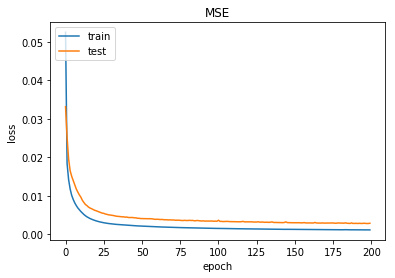

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('mse.png')

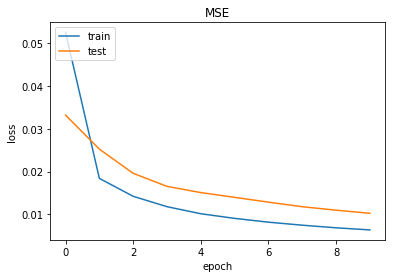

In [18]:
# summarize history for loss
plt.plot(history.history['loss'][:10])
plt.plot(history.history['val_loss'][:10])
plt.title('MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('10mse.png')

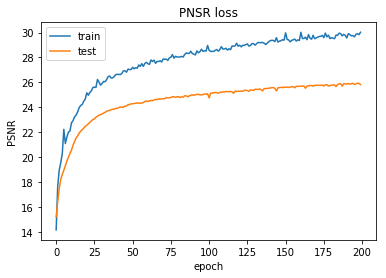

In [17]:
# summarize history for loss
plt.plot(history.history['PSNRLoss'])
plt.plot(history.history['val_PSNRLoss'])
plt.title('PNSR loss')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('psnr.png')

In [20]:
model.save_weights('1608Stable_adam_checkpoint.h5')